# 라이브러리 Import

In [ ]:
import random
import pandas as pd
import numpy as np
import os

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.models as models
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader, random_split

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings(action='ignore')

from glob import glob
import shutil

import seaborn as sns
import matplotlib.pyplot as plt
import time

import cv2
from imblearn.over_sampling import SMOTE
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Hyperparameter Setting

In [ ]:
CFG = {
    'IMG_SIZE':224,
    'EPOCHS':10,
    'LEARNING_RATE':3e-4,
    'BATCH_SIZE':32,
    'SEED':41,
    "BASE_DIR" : ["/content/drive/My Drive/AWS_CV/g2/dataset_2023-10-17",
                  "/content/drive/My Drive/AWS_CV/g2/dataset_2024-01-15",
                  "/content/drive/My Drive/AWS_CV/g2/dataset_2024-01-30"],      # 데이터셋 저장 경로
    "DATASET_PATH" : "/content/drive/My Drive/AWS_CV/dataset",       # 1~5 각 폴더에서 이미지를 꺼내 NG, OK로 나누어 저장할 경로
}

# Fixed RandomSeed

In [ ]:
def seed_everything(seed):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

# Data Pre-processing (이미지 이동 필요할 때만 주석 해제하여 사용)

In [ ]:
# # 14분
# # 새로운 폴더 구조 생성 (train/NG, train/OK)
# os.makedirs(os.path.join(CFG["DATASET_PATH"], 'NG'), exist_ok=True)
# os.makedirs(os.path.join(CFG["DATASET_PATH"], 'OK'), exist_ok=True)

# # NG 이미지 파일 이동 (tqdm 적용)
# for base_dir in CFG["BASE_DIR"]:
#   ng_source_paths = glob(os.path.join(base_dir, 'NG', '*', '*'))
#   for file_path in tqdm(ng_source_paths, desc='Moving NG Images', leave=False):
#     channel = file_path.split('/')[-2]
#     file_name = os.path.basename(file_path).split('.')
#     new_file_name = f"{file_name[0]}_{channel}.{file_name[1]}" # 동일한 주물을 여러 각도에서 촬영한 경우, 파일명이 중복되기 때문에 채널명을 붙임
#     target_path = os.path.join(CFG["DATASET_PATH"], 'NG', new_file_name)
#     shutil.copy(file_path, target_path)

# # OK 이미지 파일 이동 (tqdm 적용)
# for base_dir in CFG["BASE_DIR"]:
#   ok_source_paths = glob(os.path.join(base_dir, 'OK', '*', '*'))
#   for file_path in tqdm(ok_source_paths, desc='Moving OK Images', leave=False):
#     channel = file_path.split('/')[-2]
#     file_name = os.path.basename(file_path).split('.')
#     new_file_name = f"{file_name[0]}_{channel}.{file_name[1]}" # 동일한 주물을 여러 각도에서 촬영한 경우, 파일명이 중복되기 때문에 채널명을 붙임
#     target_path = os.path.join(CFG["DATASET_PATH"], 'OK', new_file_name)
#     shutil.copy(file_path, target_path)

In [ ]:
print(len(glob(os.path.join(CFG["DATASET_PATH"], 'NG', '*')))) # 490 + 235 + 100 = 825개
print(len(glob(os.path.join(CFG["DATASET_PATH"], 'OK', '*')))) # 475 + 504 + 98 = 1077개

825
1077


# Dataset Split

In [ ]:
from torch.utils.data import ConcatDataset # 임시

# 전체 데이터셋을 불러옴
dataset = datasets.ImageFolder(CFG["DATASET_PATH"])

# 데이터셋 분리 (80% 훈련, 10% 검증, 10% 테스트)
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - (train_size + val_size)
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size], generator=generator)

# resize 및 padding 처리 결과 확인

In [ ]:
# # 테스트할 이미지 경로
# image_path = '/content/drive/MyDrive/AWS_CV/dataset/NG/20231013-202440121_1.png'

# # 이미지 불러오기 (PIL 사용)
# original_img = Image.open(image_path)
# original_img = np.array(original_img)
# if len(original_img.shape) == 2:
#   original_img = cv2.cvtColor(original_img, cv2.COLOR_GRAY2BGR)

# # 리사이즈 및 패딩 처리
# resized_padded_img = resize_and_pad_image(original_img)

# # 원본 이미지와 처리된 이미지 비교 시각화
# plt.figure(figsize=(12, 6))

# # 원본 이미지 표시
# plt.subplot(1, 2, 1)
# plt.imshow(original_img)
# plt.title('Original Image')
# plt.axis('off')

# # 리사이즈 및 패딩 처리된 이미지 표시
# plt.subplot(1, 2, 2)
# plt.imshow(cv2.cvtColor(resized_padded_img, cv2.COLOR_BGR2RGB))  # BGR에서 RGB로 변환
# plt.title('Resized and Padded Image')
# plt.axis('off')

# plt.tight_layout()
# plt.show()

# SMOTE를 이용한 Over sampling

In [ ]:
def resize_and_pad_image(img, target_size=(224, 224)):
    # PIL 이미지라면 numpy 배열로 변환
    if isinstance(img, Image.Image):
        img = np.array(img)

    # 이미지가 흑백인 경우 채널 추가 (컬러로 변환)
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    # 이미지가 알파 채널(투명도)을 포함하는 경우 알파 채널 제거
    if img.shape[-1] == 4:
        img = img[:, :, :3]  # 알파 채널 제거 (RGB만 사용)

    # 이미지가 올바른 데이터 타입인지 확인 (uint8)
    img = img.astype(np.uint8)

    # 이미지 크기 가져오기
    h, w, c = img.shape
    target_h, target_w = target_size

    # 비율 유지하면서 이미지 크기 조정
    scale = min(target_w / w, target_h / h)
    new_w, new_h = int(w * scale), int(h * scale)
    resized_img = cv2.resize(img, (new_w, new_h))

    # 패딩 추가하여 target_size로 맞춤
    top_pad = (target_h - new_h) // 2
    bottom_pad = target_h - new_h - top_pad
    left_pad = (target_w - new_w) // 2
    right_pad = target_w - new_w - left_pad

    padded_img = cv2.copyMakeBorder(
        resized_img,
        top_pad,
        bottom_pad,
        left_pad,
        right_pad,
        cv2.BORDER_CONSTANT,
        value=[0, 0, 0]  # 검은색 패딩 추가
    )

    # 결과 이미지가 올바른 데이터 타입인지 확인
    return padded_img.astype(np.uint8)

Extracting train dataset:   0%|          | 0/1521 [00:00<?, ?it/s]

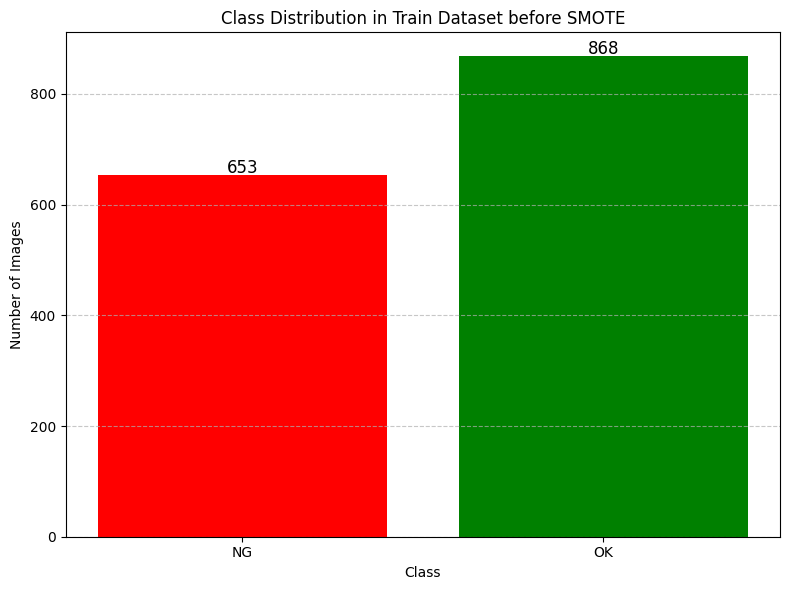

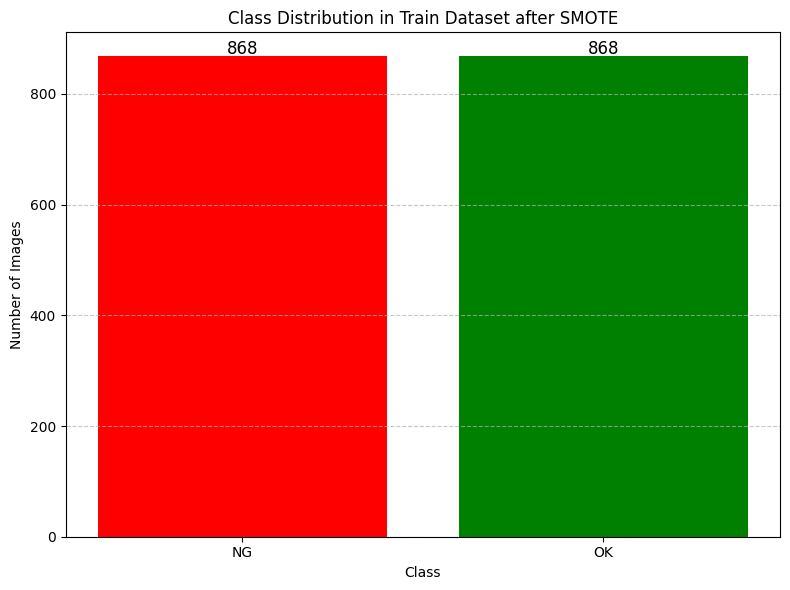

In [ ]:
# 10분

# 학습 데이터 추출
train_images = []
train_labels = []

# train_dataset에서 이미지와 라벨을 리스트로 추출
for img, label in tqdm(train_dataset, desc='Extracting train dataset'):
    img = np.array(img)
    img = resize_and_pad_image(img)
    train_images.append(img)
    train_labels.append(label)

train_images = np.array(train_images)
train_labels = np.array(train_labels)

# SMOTE 적용 전 클래스 비율 확인
ng_count_before = sum(train_labels == 0)
ok_count_before = sum(train_labels == 1)

# 클래스 비율 그래프 그리기 (SMOTE 전)
plt.figure(figsize=(8, 6))
plt.bar(['NG', 'OK'], [ng_count_before, ok_count_before], color=['red', 'green'])
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Train Dataset before SMOTE')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 수치 표시
for i, count in enumerate([ng_count_before, ok_count_before]):
    plt.text(i, count + 5, str(count), ha='center', fontsize=12)

plt.tight_layout()
plt.show()

# 학습 데이터에 SMOTE 적용
n_samples, height, width, channels = train_images.shape
train_images_reshaped = train_images.reshape(n_samples, -1)

smote = SMOTE(sampling_strategy='minority', random_state=42)
images_resampled, labels_resampled = smote.fit_resample(train_images_reshaped, train_labels)

# Resampled 데이터를 다시 원래 이미지 형태로 변환
images_resampled = images_resampled.reshape(-1, height, width, channels)

# SMOTE 적용 후 클래스 비율 확인
ng_count_after = sum(labels_resampled == 0)
ok_count_after = sum(labels_resampled == 1)

# 클래스 비율 그래프 그리기 (SMOTE 후)
plt.figure(figsize=(8, 6))
plt.bar(['NG', 'OK'], [ng_count_after, ok_count_after], color=['red', 'green'])
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Class Distribution in Train Dataset after SMOTE')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 수치 표시
for i, count in enumerate([ng_count_after, ok_count_after]):
    plt.text(i, count + 5, str(count), ha='center', fontsize=12)

plt.tight_layout()
plt.show()


# CustomDataset 만들기

In [ ]:
class CustomDataset(Dataset): # Dataset 클래스를 상속하여 훈련과 검증 데이터셋에 각기 다른 변환을 적용할 수 있게 함
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]

        # 이미지가 PIL 이미지라면 numpy 배열로 변환
        if isinstance(img, Image.Image):
            img = np.array(img)

        if isinstance(img, np.ndarray):
          # 컬러 이미지인 경우 (채널 수가 3인 경우)
          if len(img.shape) == 3 and img.shape[2] == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
          # 흑백 이미지인 경우 (채널 수가 1 또는 2차원)
          elif len(img.shape) == 2 or (len(img.shape) == 3 and img.shape[2] == 1):
            # 흑백 이미지는 그대로 사용
            pass
          else:
            raise ValueError(f"Unexpected image shape: {img.shape}")
        else:
          raise TypeError(f"Expected image to be a numpy array, but got {type(img)}")

        if self.transform:
            img = self.transform(img)

        label = self.labels[idx]
        return img, label

In [ ]:
# 훈련 데이터 preprocessing 및 augmentation 파이프라인
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(degrees=10), # 최대 10도 회전
    transforms.RandomHorizontalFlip(p=0.5), # 50% 확률로 좌우 반전
    transforms.RandomVerticalFlip(p=0.5), # 50% 확률로 상하 반전
    transforms.ColorJitter(brightness=0.2, contrast=0.2), # 밝기 및 대비 조정
    transforms.ToTensor(), # 텐서로 변환
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # 정규화
])

# 검증, 테스트 데이터 preprocessing 파이프라인
val_test_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(), # 텐서로 변환
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # 정규화
])

In [ ]:
# SMOTE로 생성된 데이터를 포함한 학습 데이터셋 생성
smote_dataset = CustomDataset(images_resampled, labels_resampled, transform=train_transforms)

In [ ]:
len(smote_dataset)

1736

In [ ]:
# 훈련, 검증, 테스트 데이터셋에 transform 적용
train_dataset = CustomDataset(images_resampled, labels_resampled, transform=train_transforms)

val_images = [resize_and_pad_image(img) for img, _ in val_dataset]
val_labels = [label for _, label in val_dataset]
val_dataset = CustomDataset(val_images, val_labels, transform=val_test_transforms)

test_images = [resize_and_pad_image(img) for img, _ in test_dataset]
test_labels = [label for _, label in test_dataset]
test_dataset = CustomDataset(test_images, test_labels, transform=val_test_transforms)

In [ ]:
# DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [ ]:
print(len(train_loader.dataset)) # 1736
print(len(val_loader.dataset)) # 190
print(len(test_loader.dataset)) # 191

1736
190
191


# Model 정의 (Pretrained EfficientNet 사용)

In [ ]:
class BaseModel(nn.Module):
    def __init__(self, num_classes=2):
        super(BaseModel, self).__init__()
        self.backbone = models.efficientnet_b0(pretrained=True)
        self.classifier = nn.Linear(1000, num_classes)

    def forward(self, x):
        x = self.backbone(x)
        x = self.classifier(x)
        return x

# Training

In [ ]:
def train(model, optimizer, train_loader, test_loader, scheduler, device, patience=5):
    model.to(device)

    criterion = nn.CrossEntropyLoss().to(device)

    best_accuracy = 0
    best_model = None
    no_improvement_epochs = 0  # 조기 종료를 위한 개선되지 않은 에폭 수

    # 학습 과정에서 손실과 정확도를 기록할 리스트
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(1,CFG["EPOCHS"]+1):
        model.train()
        train_loss = []
        train_correct = 0
        train_total = 0

        for img, label in tqdm(iter(train_loader)):
            img, label = img.float().to(device), label.to(device)

            optimizer.zero_grad()

            model_pred = model(img)

            loss = criterion(model_pred, label)

            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

            # Accuracy 계산
            _, preds = torch.max(model_pred, 1)
            train_correct += (preds == label).sum().item()
            train_total += label.size(0)

        tr_loss = np.mean(train_loss)
        train_losses.append(tr_loss)
        tr_accuracy = train_correct / train_total
        train_accuracies.append(tr_accuracy)

        val_loss, val_accuracy = validation(model, criterion, test_loader, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch}], Train Loss : [{tr_loss:.5f}] Train Accuracy: [{tr_accuracy:.5f}] Val Loss : [{val_loss:.5f}] Val Accuracy : [{val_accuracy:.5f}]')

        # 스케줄러 스텝 (ReduceLROnPlateau는 검증 손실을 기준으로 함)
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(val_loss)
        elif scheduler is not None:
            scheduler.step()

        # 최상의 모델 저장
        if best_accuracy < val_accuracy:
            best_model = model
            best_accuracy = val_accuracy
            no_improvement_epochs = 0  # 개선이 이루어지면 초기화
        else:
            no_improvement_epochs += 1

        # 조기 종료 체크
        # if no_improvement_epochs >= patience:
        #     print(f"Early stopping triggered after {epoch} epochs. Best Val Accuracy: {best_accuracy:.5f}")
        #     break

    # 학습 및 검증 손실과 정확도 그래프 그리기
    plt.figure(figsize=(14, 6))

    # 손실 그래프
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train and Validation Loss')
    plt.legend()

    # 정확도 그래프
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy', color='blue')
    plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Train and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return best_model

# Validation

In [ ]:
def validation(model, criterion, test_loader, device):
    model.eval()

    model_preds = []
    true_labels = []

    val_loss = []

    with torch.no_grad():
        for img, label in tqdm(iter(test_loader)):
            img, label = img.float().to(device), label.to(device)

            model_pred = model(img)

            loss = criterion(model_pred, label)

            val_loss.append(loss.item())

            model_preds += model_pred.argmax(1).detach().cpu().numpy().tolist()
            true_labels += label.detach().cpu().numpy().tolist()

    return np.mean(val_loss), accuracy_score(true_labels, model_preds)

# Run

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 94.5MB/s]


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.55298] Train Accuracy: [0.71947] Val Loss : [0.37546] Val Accuracy : [0.85263]


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.37461] Train Accuracy: [0.84793] Val Loss : [0.30086] Val Accuracy : [0.88947]


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.27350] Train Accuracy: [0.90035] Val Loss : [0.08039] Val Accuracy : [0.98421]


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.20970] Train Accuracy: [0.92166] Val Loss : [0.18745] Val Accuracy : [0.95263]


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.17853] Train Accuracy: [0.94182] Val Loss : [0.06097] Val Accuracy : [0.97895]


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.18941] Train Accuracy: [0.93664] Val Loss : [0.08523] Val Accuracy : [0.95789]


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.13556] Train Accuracy: [0.95161] Val Loss : [0.04669] Val Accuracy : [0.98421]


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.12681] Train Accuracy: [0.95276] Val Loss : [0.15017] Val Accuracy : [0.93158]


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.12099] Train Accuracy: [0.96371] Val Loss : [0.03661] Val Accuracy : [0.97895]


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.12441] Train Accuracy: [0.96486] Val Loss : [0.18383] Val Accuracy : [0.93158]


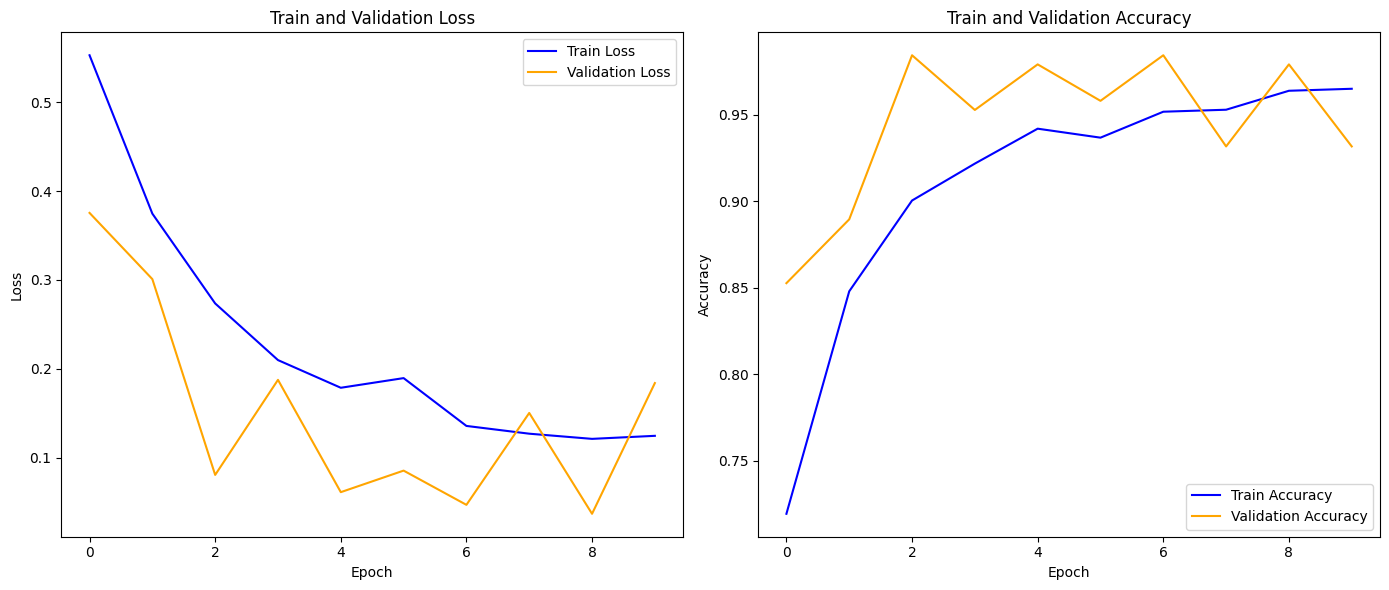

In [ ]:
# 4분
model = BaseModel()
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device, patience=5)

In [ ]:
torch.save(infer_model, 'model.pth')

## Inference

In [ ]:
def inference(model, test_loader, device):
  model.to(device)
  model.eval()

  model_preds = []
  model_probs = []  # 예측 확률 저장 리스트
  total_time = 0.0
  total_images = 0

  start_event = torch.cuda.Event(enable_timing=True)
  end_event = torch.cuda.Event(enable_timing=True)

  with torch.no_grad():
    for img, _ in tqdm(iter(test_loader)):
      batch_size = img.size(0)  # 현재 배치의 이미지 개수
      img = img.float().to(device)
      total_images += batch_size

      if device == 'cuda':
        torch.cuda.synchronize()  # GPU와 CPU 동기화

      # 추론 시작 시간 기록 (CUDA 이벤트 사용)
      if device == 'cuda':
        start_event.record()
      else:
        start_time = time.time()

      # 모델 예측
      model_pred = model(img)
      probabilities = F.softmax(model_pred, dim=1)  # 각 클래스에 대한 확률 계산

      # 추론 종료 시간 기록
      if device == 'cuda':
        end_event.record()
        torch.cuda.synchronize()
        batch_time = start_event.elapsed_time(end_event) / 1000.0  # milliseconds to seconds
      else:
        end_time = time.time()
        batch_time = end_time - start_time

      # 배치별 추론 시간 누적
      total_time += batch_time

      # 예측 라벨 및 확률 저장
      model_preds += model_pred.argmax(1).detach().cpu().numpy().tolist()
      model_probs += probabilities.detach().cpu().numpy().tolist()

  # 총 추론 시간 및 평균 추론 시간 계산
  avg_inference_time = total_time / total_images

  print(f'Total Inference Time: {total_time:.2f} seconds')
  print(f'Average Inference Time per Image: {avg_inference_time:.4f} seconds')

  print('Done.')
  return model_preds, model_probs

In [ ]:
preds, probs = inference(infer_model, test_loader, device)

  0%|          | 0/6 [00:00<?, ?it/s]

Total Inference Time: 0.42 seconds
Average Inference Time per Image: 0.0022 seconds
Done.


# Accuracy 계산

In [ ]:
# 실제 정답 라벨
true_labels = [label for _, label in test_dataset] # 또는 DataLoader에서 정답 라벨을 추출할 수 있음

# 정확도 계산
accuracy = accuracy_score(true_labels, preds)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 94.24%


# 성능 지표 계산 (precision, recall, F1-score)

In [ ]:
# 성능 지표 출력
print(classification_report(true_labels, preds, target_names=['NG', 'OK']))

              precision    recall  f1-score   support

          NG       0.92      0.95      0.94        87
          OK       0.96      0.93      0.95       104

    accuracy                           0.94       191
   macro avg       0.94      0.94      0.94       191
weighted avg       0.94      0.94      0.94       191



# Confusion Matrix 시각화

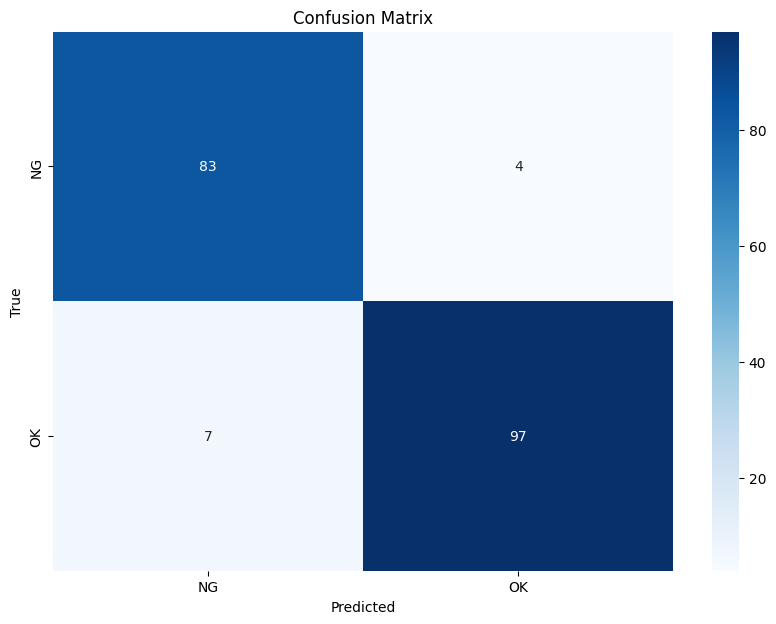

In [ ]:
# Confusion Matrix 계산
cm = confusion_matrix(true_labels, preds)

# 시각화
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['NG', 'OK'], yticklabels=['NG', 'OK'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 잘못 분류된 이미지 시각화

In [ ]:
class GradCam:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Register hooks to capture gradients and activations
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_in, grad_out):
        self.gradients = grad_out[0].detach()

    def __call__(self, input_tensor, class_idx=None):
        # Forward pass
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = output.argmax().item()

        # Zero gradients
        self.model.zero_grad()

        # Backward pass for the target class
        target = output[0, class_idx]
        target.backward()

        # Compute GradCam heatmap
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        gradcam = (weights * self.activations).sum(dim=1, keepdim=True)
        gradcam = F.relu(gradcam)
        gradcam = F.interpolate(gradcam, size=(input_tensor.shape[2], input_tensor.shape[3]), mode='bilinear', align_corners=False)
        gradcam = gradcam.squeeze().cpu().numpy()
        gradcam = (gradcam - gradcam.min()) / (gradcam.max() - gradcam.min())  # Normalize to [0, 1]
        return gradcam

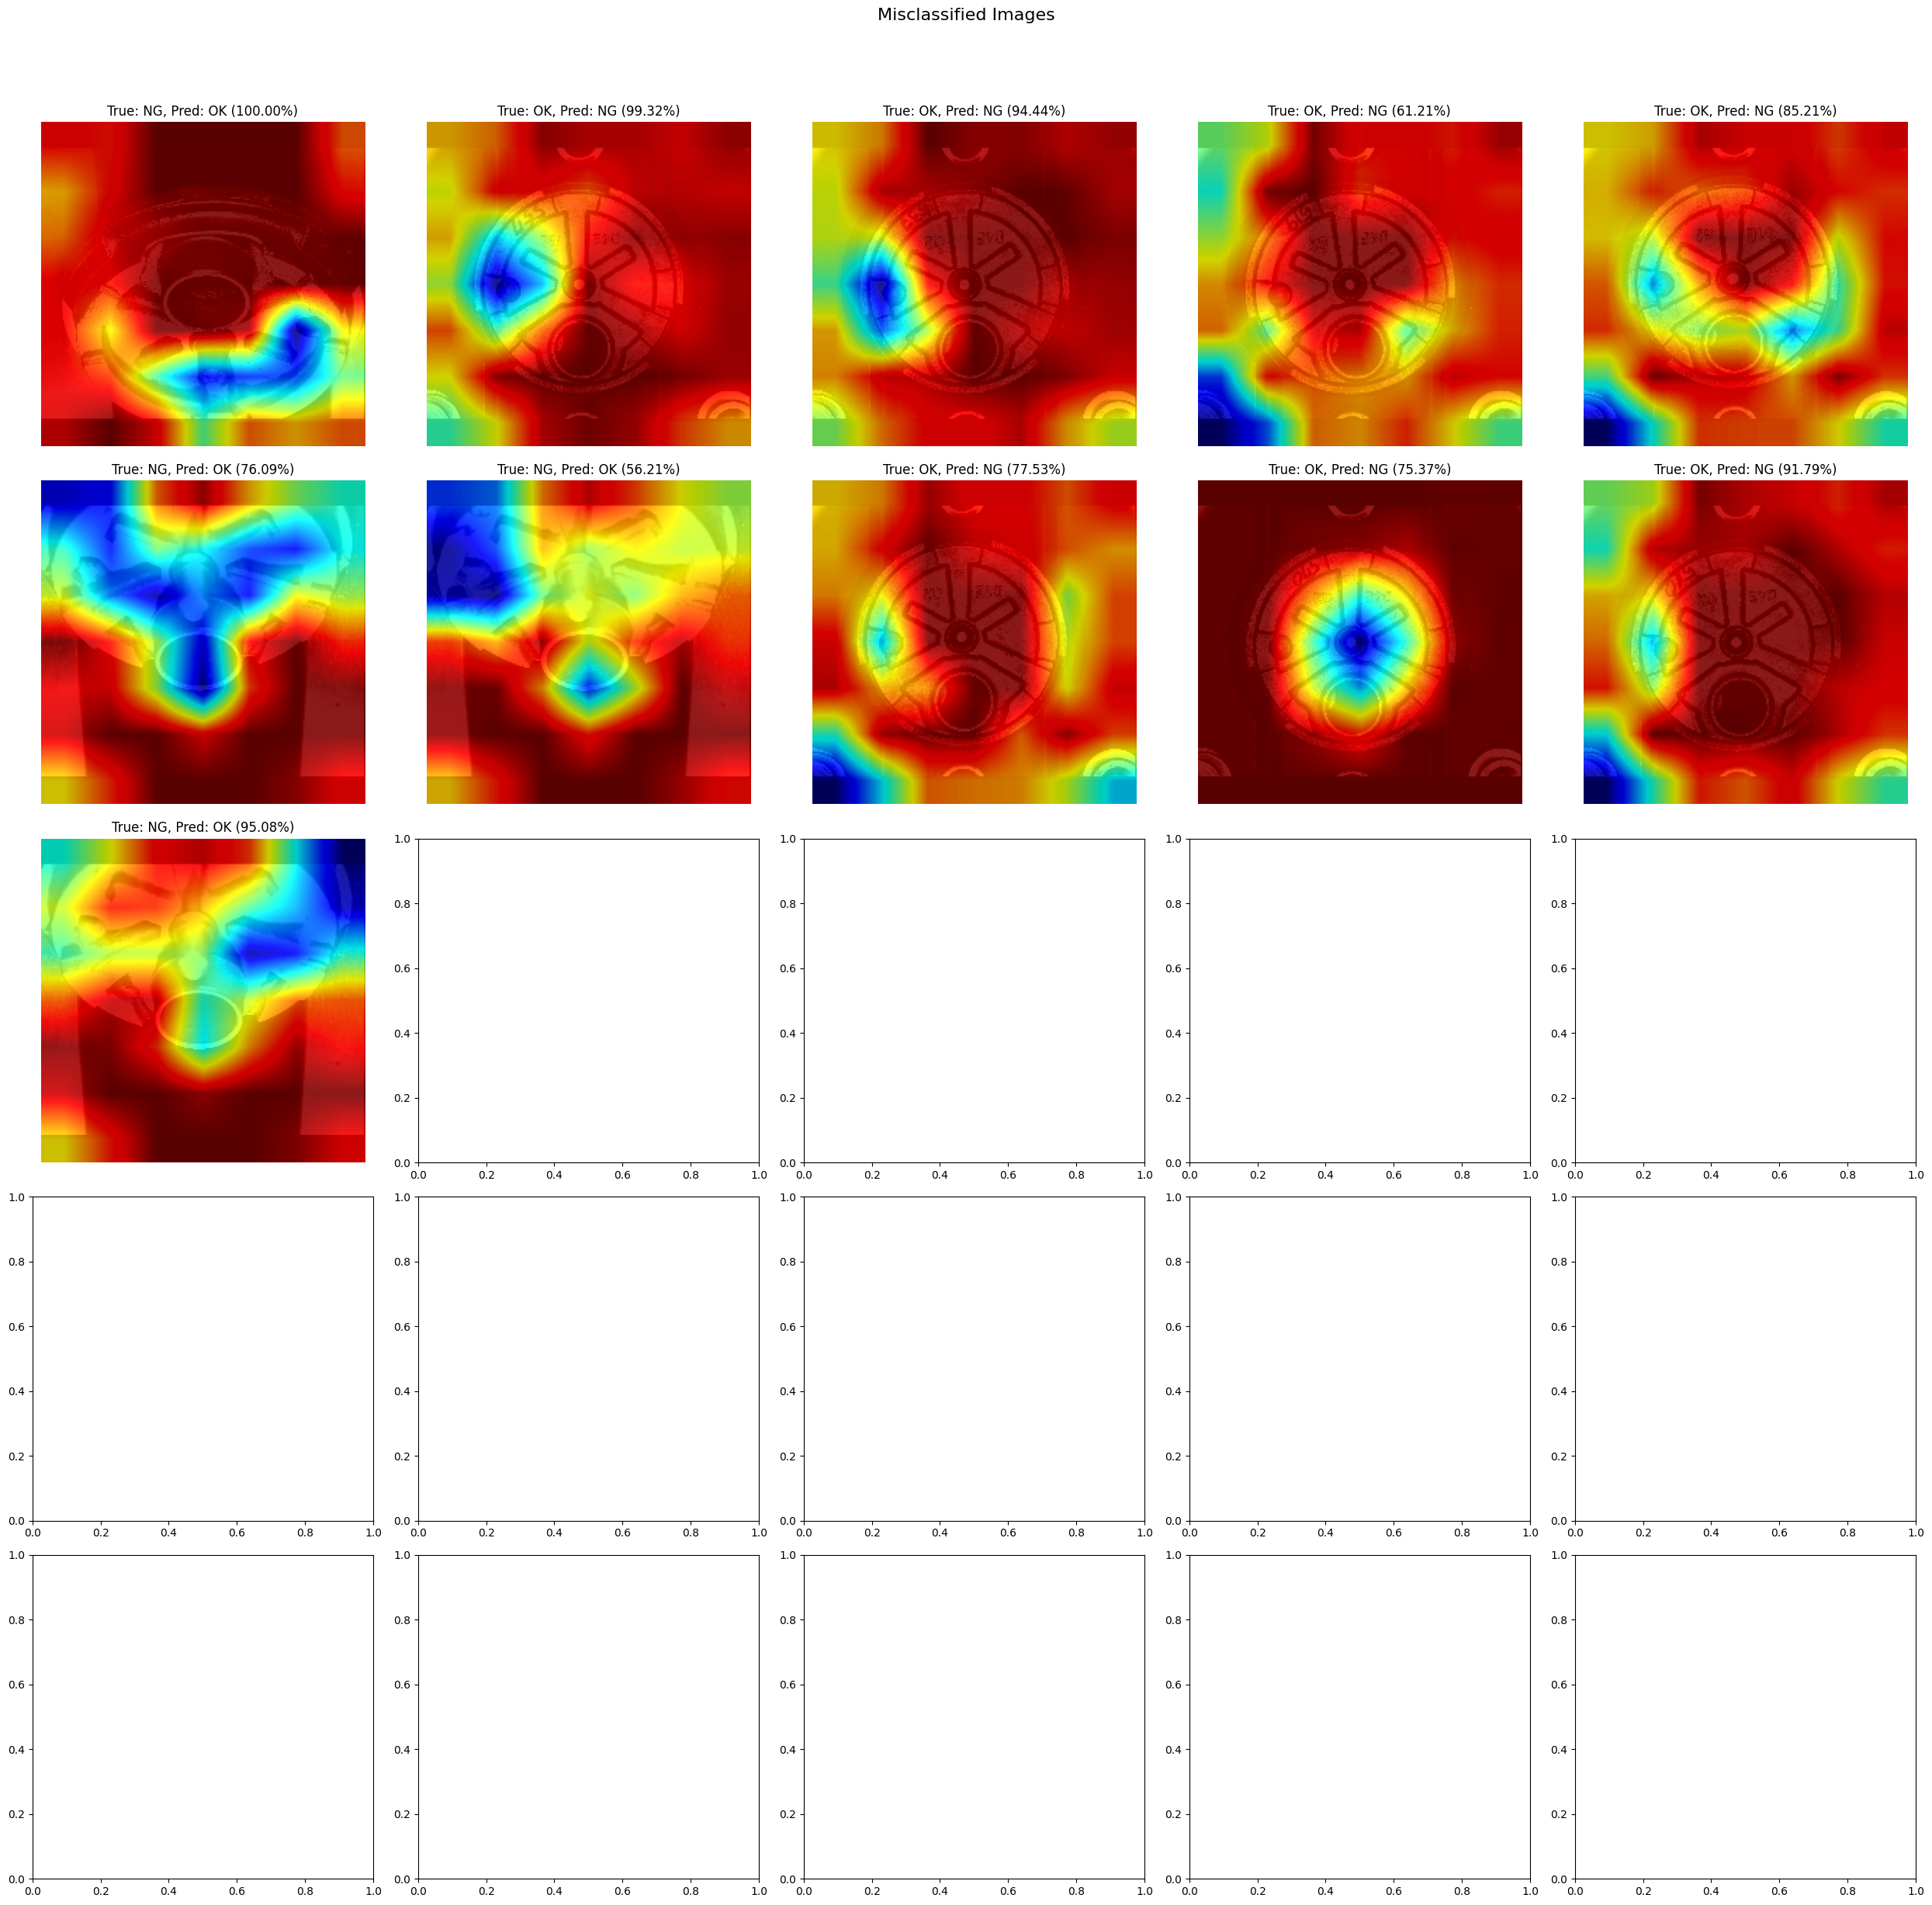

In [ ]:
# true_labels와 preds를 사용해 잘못 분류된 인덱스 찾기
misclassified_indices = [i for i in range(len(true_labels)) if true_labels[i] != preds[i]]

classes = ['NG', 'OK']

if len(misclassified_indices) > 0:
  fig, axes = plt.subplots(5, 5, figsize=(25, 25))
  fig.suptitle('Misclassified Images', fontsize=16)

  # GradCam 객체 생성
  gradcam = GradCam(model, target_layer=model.backbone.features[-1])

  for i, ax in enumerate(axes.flat):
    if i >= len(misclassified_indices):
      break
    idx = misclassified_indices[i]
    img, true_label = test_dataset[idx]  # test_dataset에서 잘못 분류된 인덱스의 이미지와 라벨 가져오기

    img_tensor = val_test_transforms(img).unsqueeze(0).to(device)  # 이미지 전처리 및 배치 차원 추가
    heatmap = gradcam(img_tensor)  # GradCam 결과 계산

    img = img.permute(1, 2, 0).numpy()  # 이미지 형태 변환 (C, H, W) -> (H, W, C) for plotting
    # img = img.astype(np.float32) / 255.0  # 이미지 타입 변환 및 정규화
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = heatmap.astype(np.float32) / 255.0  # heatmap 타입 변환 및 정규화

    # 이미지와 heatmap을 합성
    overlay = cv2.addWeighted(img, 0.1, heatmap, 0.9, 0)

    pred_label = preds[idx]  # 예측 라벨 가져오기
    pred_prob = probs[idx][pred_label] * 100  # 예측한 라벨의 확률 가져오기

    ax.imshow(overlay)
    ax.axis('off')
    ax.set_title(f'True: {classes[true_label]}, Pred: {classes[pred_label]} ({pred_prob:.2f}%)', color='black')

  plt.tight_layout(rect=[0, 0, 1, 0.95])
  plt.show()
else:
  print("No misclassified images found.")